# Keeping because some plotting code might be useful in future

In [131]:
import CM_code.spurious_george as sp
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy
import importlib as imp
import DL_basis_code.shared_functions_setup as setup
import CM_code.tjp_helper as tjp_helper
import time
import cmasher as cmr
import pandas as pd

imp.reload(tjp_helper)
imp.reload(sp)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

print('Lens bin: %g - %g'%(sp.zed.zl_min, sp.zed.zl_max))
print('Source bin: %g - %g'%(sp.zed.zs_min, sp.zed.zs_max))

Lens bin: 1 - 1.2
Source bin: 0.05 - 3.5


### Load in y1 and 10 IA data with mbias covariance

In [386]:
zlmins = [0.2, 0.6, 1.0]
zlmaxs = [0.4, 0.8, 1.2]
rhos = [0.1, 0.5, 0.9]

boost_files = ['generated_data/boost_y1_lowZ.npz', 
               'generated_data/boost_y1_midZ.npz',
               'generated_data/boost_y1_highZ.npz']

cov_files = ['generated_data/Y1_stat+sys_cov_lowZ.npz',
             'generated_data/Y1_stat+sys_cov_midZ.npz',
             'generated_data/Y1_stat+sys_cov_highZ.npz']

IA_files = ['generated_data/Y1_IA_1h+NLA_lowZ.npz',
            'generated_data/Y1_IA_1h+NLA_midZ.npz',
            'generated_data/Y1_IA_1h+NLA_highZ.npz']

year = 1

yIA_Z = []
for zl in range(len(zlmins)):
    
    B_min1 = np.load(boost_files[zl])['B_min1']
    r_p = np.load(boost_files[zl])['rp'] # Mpc/h
    F_theta = sp.get_F(zlmin=zlmins[zl], zlmax=zlmaxs[zl], year=year)
    
    y_IA = np.load(IA_files[zl])['yIA'] / (B_min1 + F_theta)
    sigmaIA = np.load(cov_files[zl])['sigma_IA']
    
    _, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmins[zl], zlmax=zlmaxs[zl], year=year)
    theta = sp.rp_to_arcmin(r_p, zleff)

    a = [0.3,0.5,0.7]
    y_1mina = np.zeros([len(a),len(y_IA)])
    for i in range(len(a)):
        y_1mina[i,:] = (1.-a[i]) * y_IA[:]
        
    
    yIA_Z.append([y_1mina, sigmaIA, theta])

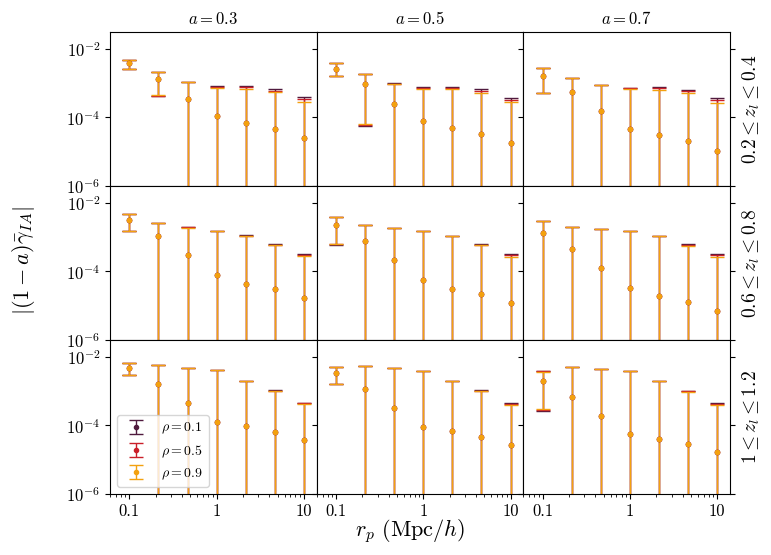

In [387]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3,
                                                                       sharey=True,
                                                                       sharex=True,
                                                                       figsize=[8,6],
                                                                       gridspec_kw={'hspace':0,'wspace':0})

#plt.yscale('log')
axs = [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]]

colors = cmr.take_cmap_colors('cmr.ember', 3, cmap_range=(0.25, 0.85), return_fmt='hex')

for row in range(len(axs)):
    
    axs[row][-1].yaxis.set_label_position('right')
    axs[row][-1].set_ylabel(r'$%g \leq z_{l} \leq %g$'%(zlmins[row], zlmaxs[row]),
                           fontsize=14)
    
    for col in range(len(axs[row])):
        
        
        axs[row][col].tick_params(axis='both',which='both',direction='out',
                                  right=True, labelsize=12)
        axs[row][col].set_xscale('log')
        axs[row][col].set_yscale('log')
        axs[0][col].set_title(r'$a = %g$'%a[col])
        
        
        for j in range(len(rhos)):
            axs[row][col].errorbar(r_p, -yIA_Z[row][0][col], yIA_Z[row][1][j], 
                        linewidth=0, marker='o', markersize=3., 
                        color=colors[j],
                        elinewidth=1., capsize=5.)
            
ax7.legend([r'$\rho = %g$'%rhos[0],r'$\rho = %g$'%rhos[1],r'$\rho = %g$'%rhos[-1]])
            
plt.xticks([0.1, 1, 10], ['0.1','1','10'])
plt.xlim([0.06, 14])
plt.ylim([1E-6,3E-2])
fig.text(0.5, 0.04, r'$r_p$ (Mpc/$h$)', ha='center', fontsize=16)
fig.text(0.00, 0.5, r'$|(1-a)\bar{\gamma}_{IA}|$', va='center', rotation='vertical', fontsize=16)

plt.savefig('allZ_IA_full_compare.png', bbox_inches='tight', dpi=300)

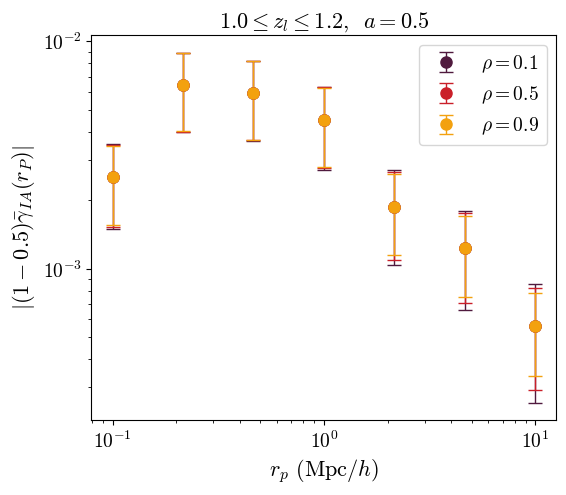

In [360]:
dat = np.load('generated_data/y1_IA_zl-1-1.2.npz')
yIA = dat['bar_yIA']
delM_yL = dat['delM_yL']

plt.figure(figsize=[6,5])
plt.xscale('log')
plt.yscale('log')

sigma_stat = np.zeros([len(rhos), len(theta)])
for i in range(len(rhos)):
    sigma_stat[i] = np.sqrt(np.diag(dat['covIA'][i]))
    
    plt.errorbar(r_p, -(1-0.5)*yIA, sigma_stat[i], 
                 linewidth=0, marker='o', markersize=8., color=colors[i],
                elinewidth=1., capsize=5.)

plt.ylabel(r'$|(1-0.5)\bar{\gamma}_{IA}(r_P)|$', fontsize=16)
plt.xlabel(r'$r_p$ (Mpc/$h$)', fontsize=16)
plt.title(r'$1.0 \leq z_{l} \leq 1.2$,  $a = 0.5$', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.legend([r'$\rho = %g$'%rhos[0],
            r'$\rho = %g$'%rhos[1],
            r'$\rho = %g$'%rhos[-1]],
            fontsize=14)

plt.savefig('highZ_IA_rho_dependence.png', bbox_inches='tight', dpi=300)

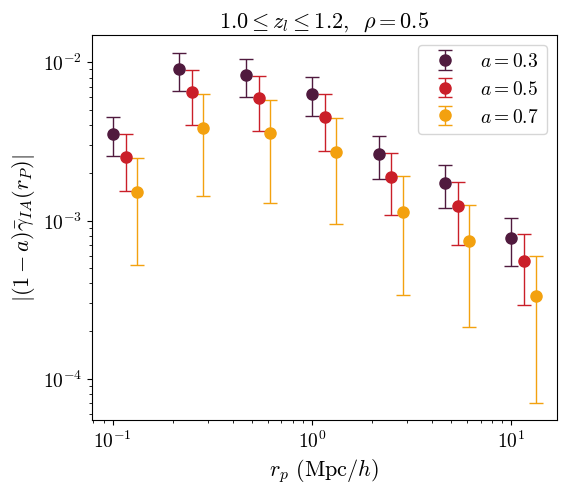

In [358]:
dat = np.load('generated_data/y1_IA_zl-1-1.2.npz')
yIA = dat['bar_yIA']
delM_yL = dat['delM_yL']

plt.figure(figsize=[6,5])
plt.xscale('log')
plt.yscale('log')

sigma = dat['sigmaIA'][1]
a = [0.3,0.5,0.7]
for i in range(len(a)):
    
    logshift = 0.16*r_p*i   
    
    plt.errorbar(r_p+logshift, -(1-a[i])*yIA, sigma, 
                 linewidth=0, marker='o', markersize=8., color=colors[i],
                elinewidth=1., capsize=5.)

plt.legend([r'$a = %g$'%a[0],r'$a = %g$'%a[1],r'$a = %g$'%a[-1]],
          fontsize=14)

plt.ylabel(r'$|(1-a)\bar{\gamma}_{IA}(r_P)|$', fontsize=16)
plt.xlabel(r'$r_p$ (Mpc/$h$)', fontsize=16)
plt.title(r'$1.0 \leq z_{l} \leq 1.2$,  $\rho = 0.5$', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.savefig('highZ_IA_a_dependence.png', bbox_inches='tight', dpi=300)